In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
from utils.data_loader import RadarDataset
from utils.plot_save import plot_confusion_matrix, save_metrics

2025-07-25 01:30:13.418743: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-25 01:30:13.442639: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-25 01:30:13.801145: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# GPU 메모리 동적 할당
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU 메모리 할당이 동적으로 설정되었습니다.")
    except RuntimeError as e:
        print(f"GPU 메모리 설정 중 오류 발생: {e}")

GPU 메모리 할당이 동적으로 설정되었습니다.


2025-07-25 01:30:14.770934: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-25 01:30:14.788126: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-25 01:30:14.788253: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
DATASET_DIR = "dataset/preprocessed_02_TestN"
label_csv_path = os.path.join(DATASET_DIR, "labels.csv")

experiment_root = "experiments/Step_02"
model_list = ["multi_effnet"]

batch_size = 1
n_classes = 15
input_shapes = {
    'rtm_input': (224,224,3),
    'dtm_input': (224,224,3)
}

class_names = [
    "hello", 
    "nice to meet you", 
    "thank you", 
    "i respect you", 
    "sign language", 
    "i love you", 
    "take care", 
    "i'm sorry",
    "be happy",
    "no gesture",
    "welcome", 
    "enjoy your meal", 
    "aha, i see",
    "i understand",
    "goodbye"    
]

In [4]:
df = pd.read_csv(label_csv_path)
df['base_id'] = df['file'].apply(lambda x: x.rsplit('_', 1)[0])
label_map = dict(zip(df['base_id'], df['label']))

base_ids = df['base_id'].unique().tolist()

# 데이터셋
test_data = RadarDataset(base_ids, label_map, batch_size=batch_size, shuffle=False, data_dir=DATASET_DIR)
test_dataset = test_data.get_dataset()

2025-07-25 01:30:14.851798: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-25 01:30:14.851933: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-25 01:30:14.852019: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-25 01:30:14.938533: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-25 01:30:14.939554: I tensorflow/compile


[테스트 평가] multi_effnet


2025-07-25 01:31:31.715043: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


 1/30 [>.............................] - ETA: 1:11 - loss: 4.2465e-04 - accuracy: 1.0000

2025-07-25 01:31:31.960240: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


30/30 [==============================] - 3s 10ms/step - loss: 7.1260e-04 - accuracy: 1.0000


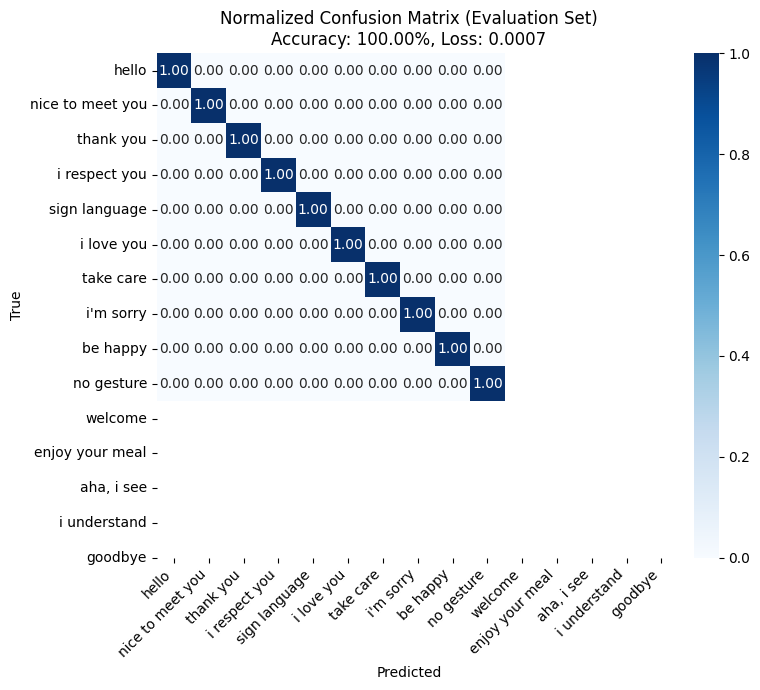

[DONE] multi_effnet (TestD): acc=1.0000, loss=0.0007


In [5]:
for model_name in model_list:
    print(f"\n[테스트 평가] {model_name}")
    model_dir = os.path.join(experiment_root, model_name)
    test_result_dir = model_dir + "_TestN"

    # 폴더 미리 생성
    os.makedirs(test_result_dir, exist_ok=True)

    # 모델 로드
    best_model = load_model(os.path.join(model_dir, "best_model.keras"))

    # 평가
    loss, acc = best_model.evaluate(test_dataset, verbose=1)

    # Confusion Matrix 계산
    y_true, y_pred = [], []
    for batch_x, batch_y in test_dataset:
        preds = best_model.predict(batch_x, verbose=0)
        y_true.extend(batch_y.numpy())
        y_pred.extend(np.argmax(preds, axis=1))

    cm = confusion_matrix(y_true, y_pred)

    # 결과 저장
    # save_metrics(acc, loss, test_result_dir, best_model.count_params(),
    #              y_true=y_true, y_pred=y_pred, class_names=class_names)
    plot_confusion_matrix(cm, save_path=test_result_dir, acc=acc, loss=loss, labels=class_names)

    print(f"[DONE] {model_name} (TestD): acc={acc:.4f}, loss={loss:.4f}")